# Parte 1: N-Rainhas
---

## Parâmetros editáveis

In [1]:
# Arquivos de jogos que serão processados
# Devem existir 3 arquivos em game_files
game_files = ["games/game10.txt", "games/game20.txt", "games/game25.txt"]

# Tamanho dos quadrados do tabuleiro (visual)
w, h = 30, 30

# Espaçamento entre os tabuleiros (visual)
hspace, vspace = 40, 40

Antes de executar este caderno, pode ser necessário instalar previamente as dependências em seu sistema. Isso pode ser feito com os seguintes comandos:
```bash
pip install --user numpy
```

## Dependencias


In [2]:
import numpy as np
import random
import time
from copy import copy, deepcopy
from PIL import Image, ImageDraw, ImageFont

## Importando os dados

In [3]:
games = []

for game_file in game_files:
    game = np.loadtxt(game_file, dtype='str', delimiter=' ')
    games.append(game)

## Funções para desenhar o tabuleiro na tela

In [4]:
# Funções para desenhar os shapes
def draw_queen(pos, q, d, bnw):
    shape = [(pos[0] + w*0.1, pos[1] + h*0.1), (pos[0] + w*0.9, pos[1] + h*0.9)]
    if not bnw:
        draw_wall(pos, d)
    else:
        draw_non_illuminated(pos,d)
    pos = (pos[0] + w/2 - 1, pos[1] + h/2 - 1)
    d.ellipse(shape, fill = 'brown', outline ='black')
    d.text(pos, str(q), fill="white")
    
def draw_non_illuminated(pos, d):
    shape = [(pos[0], pos[1]), (pos[0] + w, pos[1] + h)]
    d.rectangle(shape, fill ="white", outline ="black")

def draw_wall(pos, d):
    shape = [(pos[0], pos[1]), (pos[0] + w, pos[1] + h)]
    d.rectangle(shape, fill ="black", outline ="black")
    
# Funções para mover o cursor de desenho
def step(pos, idx_pos):
    pos = (pos[0] + w, pos[1])
    idx_pos = (idx_pos[0] + 1, idx_pos[1])
    return pos, idx_pos
    
def new_line(pos, idx_pos):
    pos = (0, pos[1] + h)
    idx_pos = (0, idx_pos[1] + 1)
    return pos, idx_pos

# Função para desenhar o tabuleiro completo
def draw_state(state, x):
    black_n_white = True
    # Desenha o outlier do tabuleiro
    img = Image.new('RGB', (x * w + 2 + hspace, x * h + 2 + vspace), color = "white")
    d = ImageDraw.Draw(img)
    # Desenhar
    pos = (0, 0)
    idx_pos = (0, 0)
    for line in state:
        if len(line) % 2 == 0:
            black_n_white = not black_n_white
        for element in line:
            black_n_white = not black_n_white
            if element == '-':
                if black_n_white:
                    draw_non_illuminated(pos, d)
                else:
                    draw_wall(pos, d)
            else:
                draw_queen(pos, 'Q', d, black_n_white)
            pos, idx_pos = step(pos, idx_pos)
        pos, idx_pos = new_line(pos, idx_pos)
    return img

## Matriz auxiliar

In [5]:
def generate_aux_matrix(game):
    matrix = {}
    for i in range(0, len(game)):
        for j in range(0,len(game)):
            l = list()
            ## Add all line cells
            for k in range(0,len(game)):
                if k != j:
                    l.append((i, k))
            ## Add all diagonal
            for k in range(0, len(game)):
                if k != j:
                    dist = abs(k - j)
                    if i + dist < len(game):
                        l.append((i + dist, k))
                    if i - dist >= 0:
                        l.append((i - dist, k))
            matrix[(i, j)] = l
    return matrix

In [6]:
class State():
    def __init__(self):
        self.queens = set()
        self.score = 2000

## Returns a set of positions. Each position represents a queen
def generate_initial_state(game):
    game_size = len(game)
    state = State()
    for j in range(0, game_size):
        i = random.randrange(0, game_size)
        state.queens.add((i, j))
    
    # print(state.queens)
    evaluate_score(state)
    return state

## Evaluate score for a set of queens.
def evaluate_score(state):
    state.score = 0
    for queen in state.queens:
        for neighbor_cell in matrix[queen]:
            if neighbor_cell in  state.queens:
                state.score += 1

## Generate next state and calculate its score. One queen is removed and other one
## is added.
def next_state_given_action(current_state, to_be_removed_queen, to_be_added_queen):
    state = deepcopy(current_state)
    queen = to_be_removed_queen
    new_queen = to_be_added_queen
    
    ## Remove queen
    state.queens.remove(queen)

    ## Update score
    for neighbor_cell in matrix[queen]:
        if neighbor_cell in state.queens:
            state.score -= 2
    
    ## Add new queen
    state.queens.add(new_queen)

    ## Update score
    for neighbor_cell in matrix[new_queen]:
        if neighbor_cell in state.queens:
            state.score += 2

    return state

## Generate next state, the one with the best score possible given
## all queen movement possibilities.
def next_state(current_state):
    # All possible next actions for a given queen
    possibleActions = {}
    for queen in current_state.queens:
        l = list()
        for i in range(0, len(game)):
            if i != queen[0]:
                l.append((i, queen[1]))
        possibleActions[queen] = l
    
    ## Find best score state given all actions for all queens
    next_state = State()
    for queen in current_state.queens:
        for action in possibleActions[queen]:
            next_possible_state = next_state_given_action(current_state, queen, action)
            if next_possible_state.score < next_state.score:
                next_state  = next_possible_state
    return next_state


## Generate simple representation of answer board.
def build_answer(state):
    board = list()
    board = copy(game)
    for queen in state.queens:
        board[queen] = 'Q'
    #print(board, state.score)
    return board


## Hill Climbing


In [7]:
solutions = []
for game in games:
    start = time.time()
    matrix = generate_aux_matrix(game)
    while True:
        current = generate_initial_state(game)
        while True:
            nextState = next_state(current)
            # build_answer(nextState)
            if nextState.score == 0:
                break
            if nextState.score < current.score:
                current = nextState
            else:
                break
        if nextState.score == 0:
            end = time.time()
            break
    solutions.append((build_answer(nextState), end-start, len(game)))

## Visualização das soluções

Solution for 10 x 10 board
Time taken:  0.3068363666534424 s


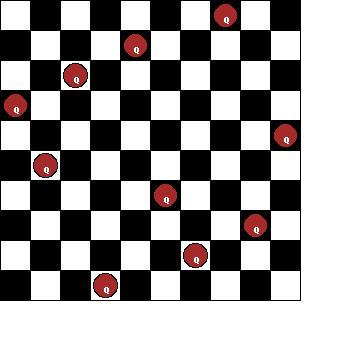

In [8]:
# Monta as imagens sem loop. 
print("Solution for", solutions[0][2], "x", solutions[0][2], "board")
print("Time taken: ", solutions[0][1], "s")
Image.fromarray(np.asarray(draw_state(solutions[0][0], solutions[0][2])))
        

Solution for 20 x 20 board
Time taken:  0.7651562690734863 s


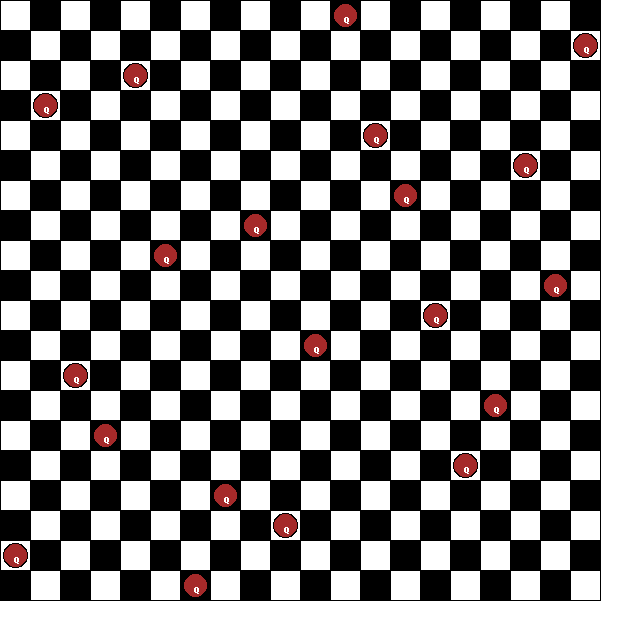

In [9]:
print("Solution for", solutions[1][2], "x", solutions[1][2], "board")
print("Time taken: ", solutions[1][1], "s")
Image.fromarray(np.asarray(draw_state(solutions[1][0], solutions[1][2])))

Solution for 25 x 25 board
Time taken:  3.5102453231811523 s


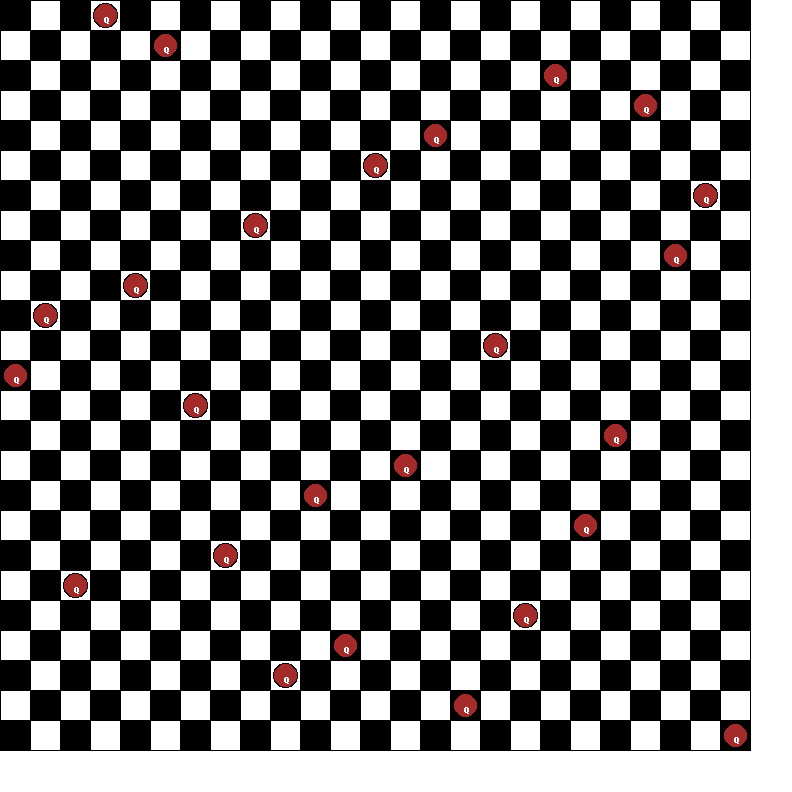

In [10]:
print("Solution for", solutions[2][2], "x", solutions[2][2], "board")
print("Time taken: ", solutions[2][1], "s")
Image.fromarray(np.asarray(draw_state(solutions[2][0], solutions[2][2])))